# Pizza I4 Architecture - Production Experiment Analysis
This notebook analyzes order and pizza production data to identify performance patterns and bottlenecks.

In [61]:
!pip install pandas numpy matplotlib seaborn scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


## 1. Data Loading and Preparation

In [62]:
# Load data
order_df = pd.read_csv('./experiment-data/order_latency.csv')
pizza_df = pd.read_csv('./experiment-data/pizza_latency.csv')

print(f"Original Orders: {len(order_df)}")
print(f"Original Pizzas: {len(pizza_df)}")

# Convert timestamps
for df in [order_df, pizza_df]:
    df['START_TIME'] = pd.to_datetime(df['STARTTIMESTAMP'], unit='ms')
    df['END_TIME'] = pd.to_datetime(df['ENDTIMESTAMP'], unit='ms', errors='coerce')
    
# Calculate latency in seconds
order_df['LATENCY_S'] = (order_df['END_TIME'] - order_df['START_TIME']).dt.total_seconds()
pizza_df['LATENCY_S'] = (pizza_df['END_TIME'] - pizza_df['START_TIME']).dt.total_seconds()

# Separate completed and incomplete
completed_orders = order_df.dropna(subset=['END_TIME']).copy()
incomplete_orders = order_df[order_df['END_TIME'].isna()].copy()

completed_pizzas = pizza_df.dropna(subset=['END_TIME']).copy()
incomplete_pizzas = pizza_df[pizza_df['END_TIME'].isna()].copy()

print(f"\nCompleted Orders: {len(completed_orders)} ({len(completed_orders)/len(order_df)*100:.1f}%)")
print(f"Incomplete Orders: {len(incomplete_orders)} ({len(incomplete_orders)/len(order_df)*100:.1f}%)")
print(f"\nCompleted Pizzas: {len(completed_pizzas)} ({len(completed_pizzas)/len(pizza_df)*100:.1f}%)")
print(f"Incomplete Pizzas: {len(incomplete_pizzas)} ({len(incomplete_pizzas)/len(pizza_df)*100:.1f}%)")

Original Orders: 40
Original Pizzas: 1610

Completed Orders: 40 (100.0%)
Incomplete Orders: 0 (0.0%)

Completed Pizzas: 1610 (100.0%)
Incomplete Pizzas: 0 (0.0%)


## 2. Order-Level Analysis

In [63]:
# Summary statistics
print("=" * 60)
print("ORDER LATENCY STATISTICS (Completed Orders Only)")
print("=" * 60)
print(f"\nMean: {completed_orders['LATENCY_S'].mean():.2f}s")
print(f"Median: {completed_orders['LATENCY_S'].median():.2f}s")
print(f"Std Dev: {completed_orders['LATENCY_S'].std():.2f}s")
print(f"Min: {completed_orders['LATENCY_S'].min():.2f}s")
print(f"Max: {completed_orders['LATENCY_S'].max():.2f}s")

# Percentiles
percentiles = [25, 50, 75, 90, 95, 99]
print("\nPercentiles:")
for p in percentiles:
    val = np.percentile(completed_orders['LATENCY_S'], p)
    print(f"  P{p}: {val:.2f}s")

# Group by order size
print("\n" + "=" * 60)
print("LATENCY BY ORDER SIZE")
print("=" * 60)
size_analysis = completed_orders.groupby('ORDERSIZE').agg({
    'LATENCY_S': ['count', 'mean', 'median', 'std', 'min', 'max']
}).round(2)
size_analysis.columns = ['Count', 'Mean(s)', 'Median(s)', 'Std(s)', 'Min(s)', 'Max(s)']
print(size_analysis)

ORDER LATENCY STATISTICS (Completed Orders Only)

Mean: 143.03s
Median: 109.78s
Std Dev: 122.90s
Min: 19.58s
Max: 334.71s

Percentiles:
  P25: 39.62s
  P50: 109.78s
  P75: 212.52s
  P90: 331.56s
  P95: 332.16s
  P99: 334.07s

LATENCY BY ORDER SIZE
           Count  Mean(s)  Median(s)  Std(s)  Min(s)  Max(s)
ORDERSIZE                                                   
1             10    21.88      21.62    1.35   19.58   24.24
10            10    49.28      49.41    2.67   44.75   53.17
50            10   171.99     173.09    3.23  166.39  176.40
100           10   328.95     330.34    4.68  320.90  334.71


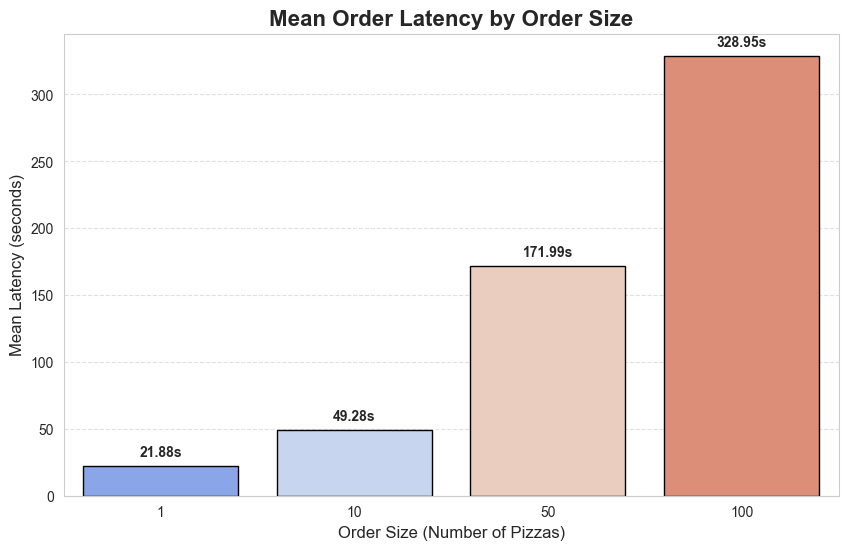

In [64]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=size_analysis.index, y=size_analysis['Mean(s)'], palette='coolwarm', edgecolor='black')

plt.title('Mean Order Latency by Order Size', fontsize=16, fontweight='bold')
plt.xlabel('Order Size (Number of Pizzas)', fontsize=12)
plt.ylabel('Mean Latency (seconds)', fontsize=12)

# Add data labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}s', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

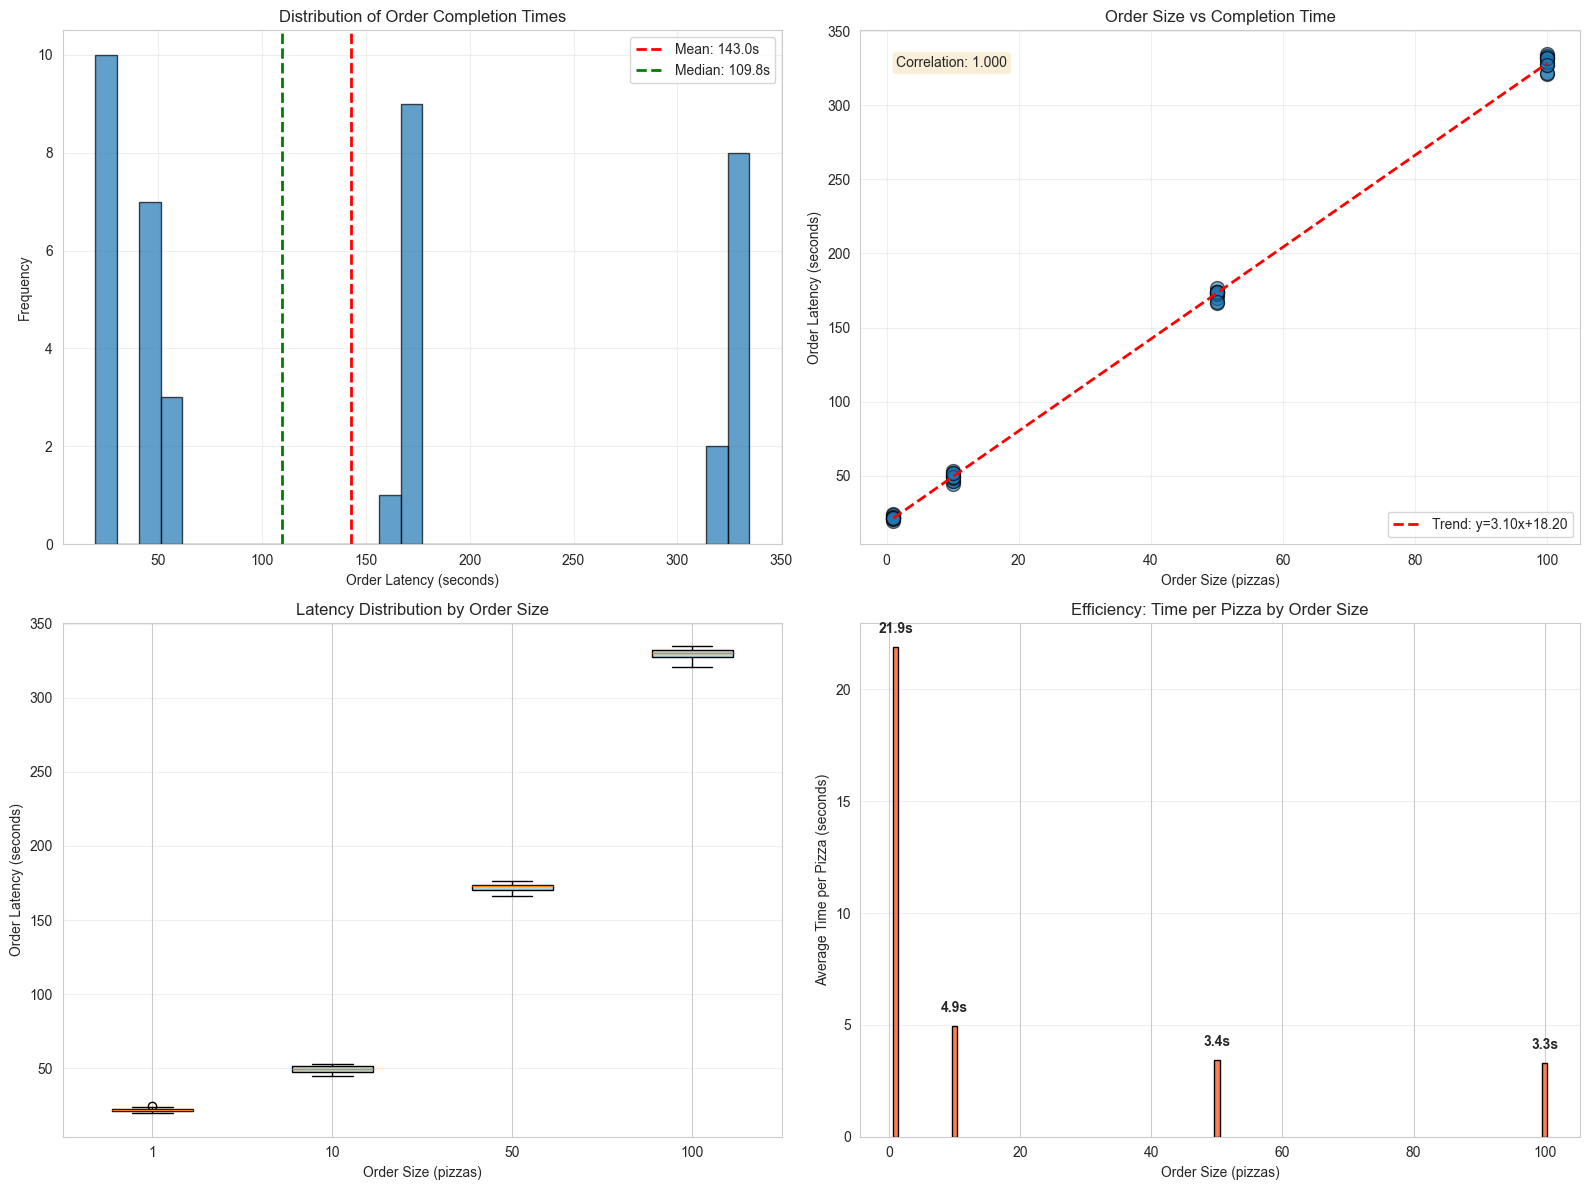

In [65]:
# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution of order latency
axes[0, 0].hist(completed_orders['LATENCY_S'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(completed_orders['LATENCY_S'].mean(), color='red', 
                   linestyle='--', linewidth=2, label=f'Mean: {completed_orders["LATENCY_S"].mean():.1f}s')
axes[0, 0].axvline(completed_orders['LATENCY_S'].median(), color='green', 
                   linestyle='--', linewidth=2, label=f'Median: {completed_orders["LATENCY_S"].median():.1f}s')
axes[0, 0].set_xlabel('Order Latency (seconds)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Order Completion Times')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Order size vs latency (scatter with trend)
axes[0, 1].scatter(completed_orders['ORDERSIZE'], completed_orders['LATENCY_S'], 
                   alpha=0.6, s=100, edgecolors='black')
z = np.polyfit(completed_orders['ORDERSIZE'], completed_orders['LATENCY_S'], 1)
p = np.poly1d(z)
x_line = np.linspace(completed_orders['ORDERSIZE'].min(), completed_orders['ORDERSIZE'].max(), 100)
axes[0, 1].plot(x_line, p(x_line), "r--", linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
axes[0, 1].set_xlabel('Order Size (pizzas)')
axes[0, 1].set_ylabel('Order Latency (seconds)')
axes[0, 1].set_title('Order Size vs Completion Time')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Calculate correlation
corr = completed_orders['ORDERSIZE'].corr(completed_orders['LATENCY_S'])
axes[0, 1].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                transform=axes[0, 1].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. Box plot by order size
order_sizes_sorted = sorted(completed_orders['ORDERSIZE'].unique())
data_for_box = [completed_orders[completed_orders['ORDERSIZE'] == size]['LATENCY_S'] 
                for size in order_sizes_sorted]
bp = axes[1, 0].boxplot(data_for_box, labels=order_sizes_sorted, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
axes[1, 0].set_xlabel('Order Size (pizzas)')
axes[1, 0].set_ylabel('Order Latency (seconds)')
axes[1, 0].set_title('Latency Distribution by Order Size')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Average latency per pizza by order size
completed_orders['LATENCY_PER_PIZZA'] = completed_orders['LATENCY_S'] / completed_orders['ORDERSIZE']
avg_per_pizza = completed_orders.groupby('ORDERSIZE')['LATENCY_PER_PIZZA'].mean()
axes[1, 1].bar(avg_per_pizza.index, avg_per_pizza.values, color='coral', edgecolor='black')
axes[1, 1].set_xlabel('Order Size (pizzas)')
axes[1, 1].set_ylabel('Average Time per Pizza (seconds)')
axes[1, 1].set_title('Efficiency: Time per Pizza by Order Size')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, v in enumerate(avg_per_pizza.values):
    axes[1, 1].text(avg_per_pizza.index[i], v + 0.5, f'{v:.1f}s', 
                    ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


## 3. Pizza-Level Analysis

In [66]:
# Merge pizza data with order size
pizza_enriched = completed_pizzas.merge(
    order_df[['ORDERID', 'ORDERSIZE']], 
    left_on='E_ORDER_ID', 
    right_on='ORDERID',
    how='left'
)

print("=" * 60)
print("PIZZA LATENCY STATISTICS")
print("=" * 60)
print(f"\nMean: {pizza_enriched['LATENCY_S'].mean():.2f}s")
print(f"Median: {pizza_enriched['LATENCY_S'].median():.2f}s")
print(f"Std Dev: {pizza_enriched['LATENCY_S'].std():.2f}s")
print(f"Min: {pizza_enriched['LATENCY_S'].min():.2f}s")
print(f"Max: {pizza_enriched['LATENCY_S'].max():.2f}s")

# Analysis by order size
print("\n" + "=" * 60)
print("PIZZA LATENCY BY ORDER SIZE")
print("=" * 60)
pizza_by_size = pizza_enriched.groupby('ORDERSIZE').agg({
    'LATENCY_S': ['count', 'mean', 'median', 'std', 'min', 'max']
}).round(2)
pizza_by_size.columns = ['Count', 'Mean(s)', 'Median(s)', 'Std(s)', 'Min(s)', 'Max(s)']
print(pizza_by_size)

PIZZA LATENCY STATISTICS

Mean: 19.65s
Median: 18.94s
Std Dev: 3.12s
Min: 14.73s
Max: 30.44s

PIZZA LATENCY BY ORDER SIZE
           Count  Mean(s)  Median(s)  Std(s)  Min(s)  Max(s)
ORDERSIZE                                                   
1             10    21.85      21.59    1.37   19.58   24.24
10           100    21.05      21.13    2.06   16.56   26.29
50           500    19.61      19.10    2.76   14.73   30.44
100         1000    19.52      18.58    3.35   14.88   30.33


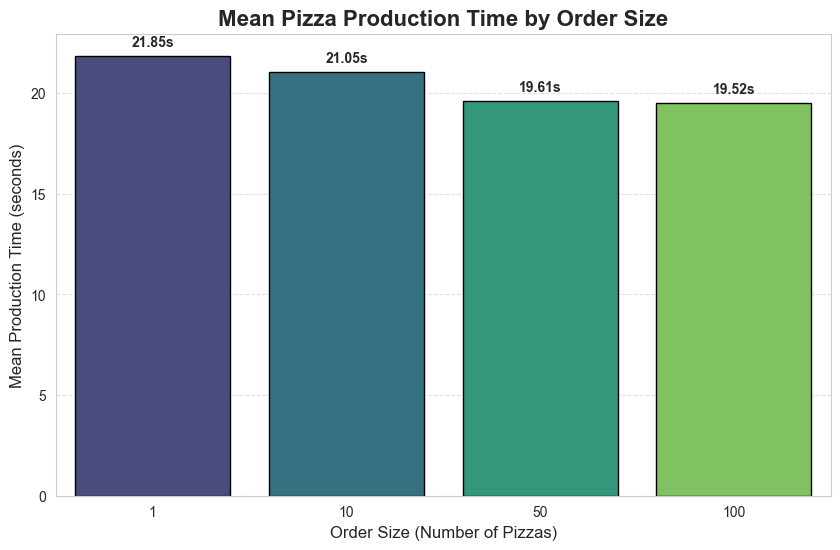

In [67]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=pizza_by_size.index, y=pizza_by_size['Mean(s)'], palette='viridis', edgecolor='black')

plt.title('Mean Pizza Production Time by Order Size', fontsize=16, fontweight='bold')
plt.xlabel('Order Size (Number of Pizzas)', fontsize=12)
plt.ylabel('Mean Production Time (seconds)', fontsize=12)

# Add data labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}s', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


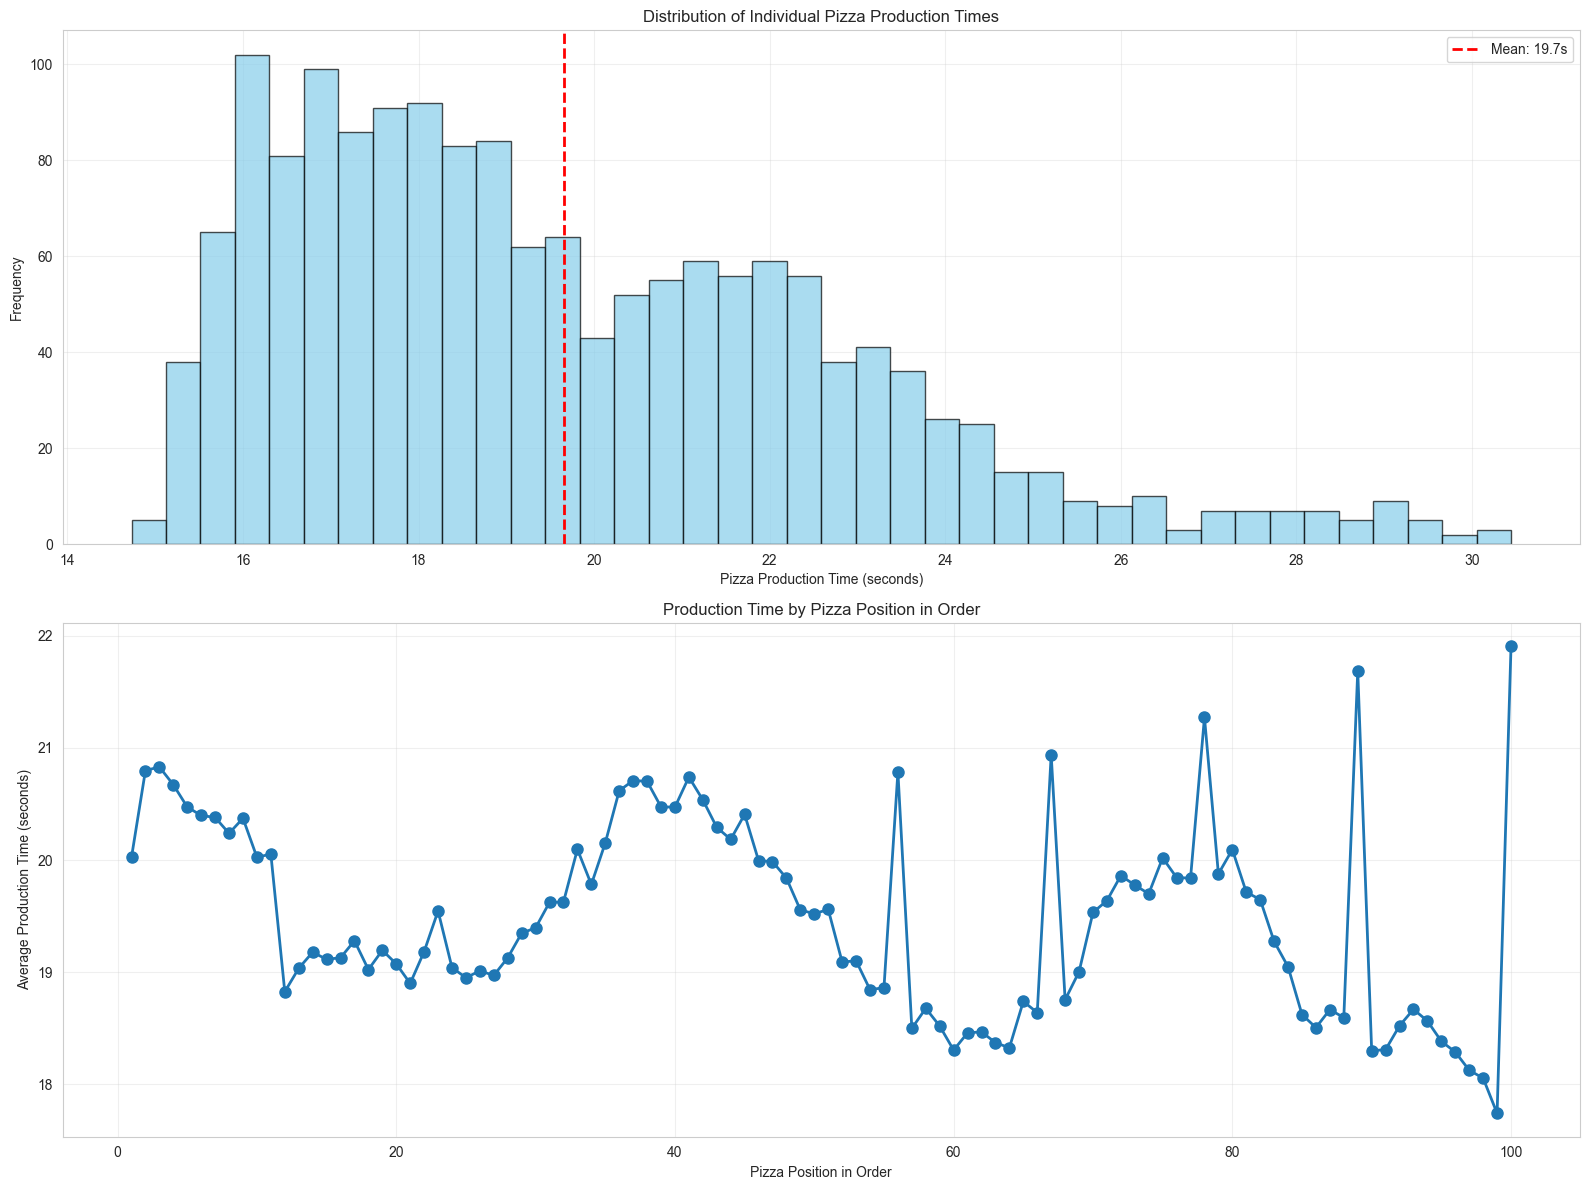

In [68]:
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# 1. Pizza latency distribution
axes[0].hist(pizza_enriched['LATENCY_S'], bins=40, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].axvline(pizza_enriched['LATENCY_S'].mean(), color='red', 
                   linestyle='--', linewidth=2, label=f'Mean: {pizza_enriched["LATENCY_S"].mean():.1f}s')
axes[0].set_xlabel('Pizza Production Time (seconds)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Individual Pizza Production Times')
axes[0].legend()
axes[0].grid(True, alpha=0.3)


# 2. Average pizza time within order (position effect)
pizza_enriched['PIZZA_POSITION'] = pizza_enriched.groupby('E_ORDER_ID').cumcount() + 1
position_analysis = pizza_enriched.groupby('PIZZA_POSITION')['LATENCY_S'].agg(['mean', 'count'])
position_analysis = position_analysis[position_analysis['count'] >= 5]  # Only positions with 5+ samples

axes[1].plot(position_analysis.index, position_analysis['mean'], marker='o', linewidth=2, markersize=8)
axes[1].set_xlabel('Pizza Position in Order')
axes[1].set_ylabel('Average Production Time (seconds)')
axes[1].set_title('Production Time by Pizza Position in Order')
axes[1].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

## 4. Order vs Pizza Comparison

In [69]:
# Compare total order time vs sum of pizza times
pizza_sum_by_order = pizza_enriched.groupby('E_ORDER_ID')['LATENCY_S'].sum().reset_index()
pizza_sum_by_order.columns = ['ORDERID', 'TOTAL_PIZZA_TIME']

comparison = completed_orders[['ORDERID', 'ORDERSIZE', 'LATENCY_S']].merge(
    pizza_sum_by_order, on='ORDERID', how='inner'
)
comparison['TIME_DIFFERENCE'] = comparison['LATENCY_S'] - comparison['TOTAL_PIZZA_TIME']
comparison['EFFICIENCY_RATIO'] = comparison['TOTAL_PIZZA_TIME'] / comparison['LATENCY_S']

print("=" * 60)
print("ORDER EFFICIENCY ANALYSIS")
print("=" * 60)
print("\nOrders where total pizza time < order time (parallel production):")
print(comparison[comparison['TIME_DIFFERENCE'] > 0][['ORDERID', 'ORDERSIZE', 'TIME_DIFFERENCE', 'EFFICIENCY_RATIO']])

print(f"\nAverage efficiency ratio: {comparison['EFFICIENCY_RATIO'].mean():.2f}")
print(f"(Ratio > 1 indicates sequential production, < 1 indicates parallel production)")

ORDER EFFICIENCY ANALYSIS

Orders where total pizza time < order time (parallel production):
                                 ORDERID  ORDERSIZE  TIME_DIFFERENCE  \
4   231bc99a-5cd8-48a7-b32c-40456f4bdfa9          1            0.001   
11  4588f331-4170-4d65-b0aa-d5b6dbd99fc1          1            0.001   
17  5c49b1f5-b5ab-49f7-83f8-3d560fc88416          1            0.001   
18  64e46540-273d-4c84-8519-575d14f7ab51          1            0.001   
19  73abe140-24e8-411a-9c9f-6779bc3fdf72          1            0.001   
21  82dfe8f8-0b2d-46ff-882f-815deec33a1d          1            0.001   
29  ac767351-917c-4581-a3ff-1f1634cdd441          1            0.186   
31  b6c8c29f-d27e-4592-8533-89b3b6307369          1            0.055   
32  c6ec9ed3-351e-4c1a-b13b-fa5ada1a903d          1            0.007   

    EFFICIENCY_RATIO  
4           0.999956  
11          0.999959  
17          0.999958  
18          0.999952  
19          0.999953  
21          0.999955  
29          0.991197  
31

## 5. Key Findings & Recommendations

In [70]:
print("=" * 70)
print(" " * 20 + "KEY FINDINGS")
print("=" * 70)

# 1. Completion rate
order_completion = len(completed_orders) / len(order_df) * 100
pizza_completion = len(completed_pizzas) / len(pizza_df) * 100
print(f"\n1. COMPLETION RATES:")
print(f"   • Orders: {order_completion:.1f}% completed")
print(f"   • Pizzas: {pizza_completion:.1f}% completed")
if order_completion < 90 or pizza_completion < 90:
    print("   ⚠ WARNING: Low completion rate may indicate system issues")

# 2. Scalability
corr = completed_orders['ORDERSIZE'].corr(completed_orders['LATENCY_S'])
print(f"\n2. SCALABILITY:")
print(f"   • Correlation (size vs time): {corr:.3f}")
if corr > 0.7:
    print("   ⚠ Strong positive correlation - system may not scale well")
elif corr > 0.4:
    print("   ⚠ Moderate correlation - some scalability concerns")
else:
    print("   ✓ Low correlation - good scalability")

# 3. Parallelization
avg_efficiency = comparison['EFFICIENCY_RATIO'].mean()
print(f"\n3. PARALLELIZATION EFFICIENCY:")
print(f"   • Average efficiency ratio: {avg_efficiency:.2f}")
if avg_efficiency > 1.2:
    print("   ⚠ Mostly sequential production - limited parallelization")
elif avg_efficiency > 0.8:
    print("   → Partial parallelization achieved")
else:
    print("   ✓ Good parallelization - efficient use of resources")

# 4. Bottlenecks
largest_orders = completed_orders.nlargest(3, 'ORDERSIZE')
print(f"\n4. POTENTIAL BOTTLENECKS:")
for _, order in largest_orders.iterrows():
    time_per_pizza = order['LATENCY_S'] / order['ORDERSIZE']
    print(f"   • Order {(order['ORDERID'])} ({int(order['ORDERSIZE'])} pizzas): {time_per_pizza:.1f}s per pizza")

# 5. Recommendations
print(f"\n5. RECOMMENDATIONS:")
if corr > 0.6:
    print("   → Consider adding more parallel processing capacity")
if avg_efficiency > 1.0:
    print("   → Optimize pizza production pipeline for better parallelization")
if pizza_completion < 95:
    print("   → Investigate causes of incomplete pizzas/orders")
if completed_orders['LATENCY_PER_PIZZA'].std() > completed_orders['LATENCY_PER_PIZZA'].mean() * 0.5:
    print("   → High variability in per-pizza time - investigate consistency issues")

print("\n" + "=" * 70)

                    KEY FINDINGS

1. COMPLETION RATES:
   • Orders: 100.0% completed
   • Pizzas: 100.0% completed

2. SCALABILITY:
   • Correlation (size vs time): 1.000
   ⚠ Strong positive correlation - system may not scale well

3. PARALLELIZATION EFFICIENCY:
   • Average efficiency ratio: 4.22
   ⚠ Mostly sequential production - limited parallelization

4. POTENTIAL BOTTLENECKS:
   • Order 32657bba-15cd-4494-bc56-8a64e907b4df (100 pizzas): 3.2s per pizza
   • Order 35b3db32-7988-4ef3-b3c9-8a2ee04ef9be (100 pizzas): 3.3s per pizza
   • Order 57c0e041-7853-4179-b45d-3ffe59d5a4ff (100 pizzas): 3.3s per pizza

5. RECOMMENDATIONS:
   → Consider adding more parallel processing capacity
   → Optimize pizza production pipeline for better parallelization
   → High variability in per-pizza time - investigate consistency issues



## 6 Restocking Analysis

In [71]:
# Load data
dough_df = pd.read_csv('./experiment-data/dough_machine_restock_latency.csv')
sauce_df = pd.read_csv('./experiment-data/sauce_machine_restock_latency.csv')
cheese_df = pd.read_csv('./experiment-data/cheese_machine_restock_latency.csv')
meat_df = pd.read_csv('./experiment-data/meat_machine_restock_latency.csv')
vegetables_df = pd.read_csv('./experiment-data/vegetables_machine_restock_latency.csv')
packaging_df = pd.read_csv('./experiment-data/packaging_machine_restock_latency.csv')

# Convert milliseconds to seconds for all dataframes
for df in [dough_df, sauce_df, cheese_df, meat_df, vegetables_df, packaging_df]:
    df['RESTOCKLATENCYSEC'] = df['RESTOCKLATENCYMS'] / 1000


# Combine all dataframes
all_machines = {
    'dough': dough_df,
    'sauce': sauce_df,
    'cheese': cheese_df,
    'meat': meat_df,
    'vegetables': vegetables_df,
    'packaging': packaging_df
}

In [72]:
# ============================================================================
# 1. BASIC STATISTICS PER MACHINE
# ============================================================================
print("=" * 80)
print("RESTOCK LATENCY ANALYSIS - SUMMARY STATISTICS")
print("=" * 80)

summary_stats = []
for machine_name, df in all_machines.items():
    stats = {
        'Machine': machine_name,
        'Count': len(df),
        'Mean (s)': df['RESTOCKLATENCYSEC'].mean(),
        'Median (s)': df['RESTOCKLATENCYSEC'].median(),
        'Std Dev (s)': df['RESTOCKLATENCYSEC'].std(),
        'Min (s)': df['RESTOCKLATENCYSEC'].min(),
        'Max (s)': df['RESTOCKLATENCYSEC'].max(),
        'P95 (s)': df['RESTOCKLATENCYSEC'].quantile(0.95),
        'P99 (s)': df['RESTOCKLATENCYSEC'].quantile(0.99)
    }
    summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)
print("\n", summary_df.to_string(index=False))

RESTOCK LATENCY ANALYSIS - SUMMARY STATISTICS

    Machine  Count  Mean (s)  Median (s)  Std Dev (s)  Min (s)  Max (s)  P95 (s)  P99 (s)
     dough     17  1.102000       1.034     0.267126    1.017    2.136   1.2936  1.96752
     sauce      9  1.042889       1.026     0.050305    1.017    1.176   1.1212  1.16504
    cheese     17  1.045588       1.035     0.037537    1.024    1.187   1.0814  1.16588
      meat      5  2.264400       2.052     0.315748    2.023    2.657   2.6374  2.65308
vegetables      9  2.047333       2.030     0.045415    2.017    2.163   2.1186  2.15412
 packaging     17  2.046588       2.027     0.069598    2.010    2.311   2.1190  2.27260


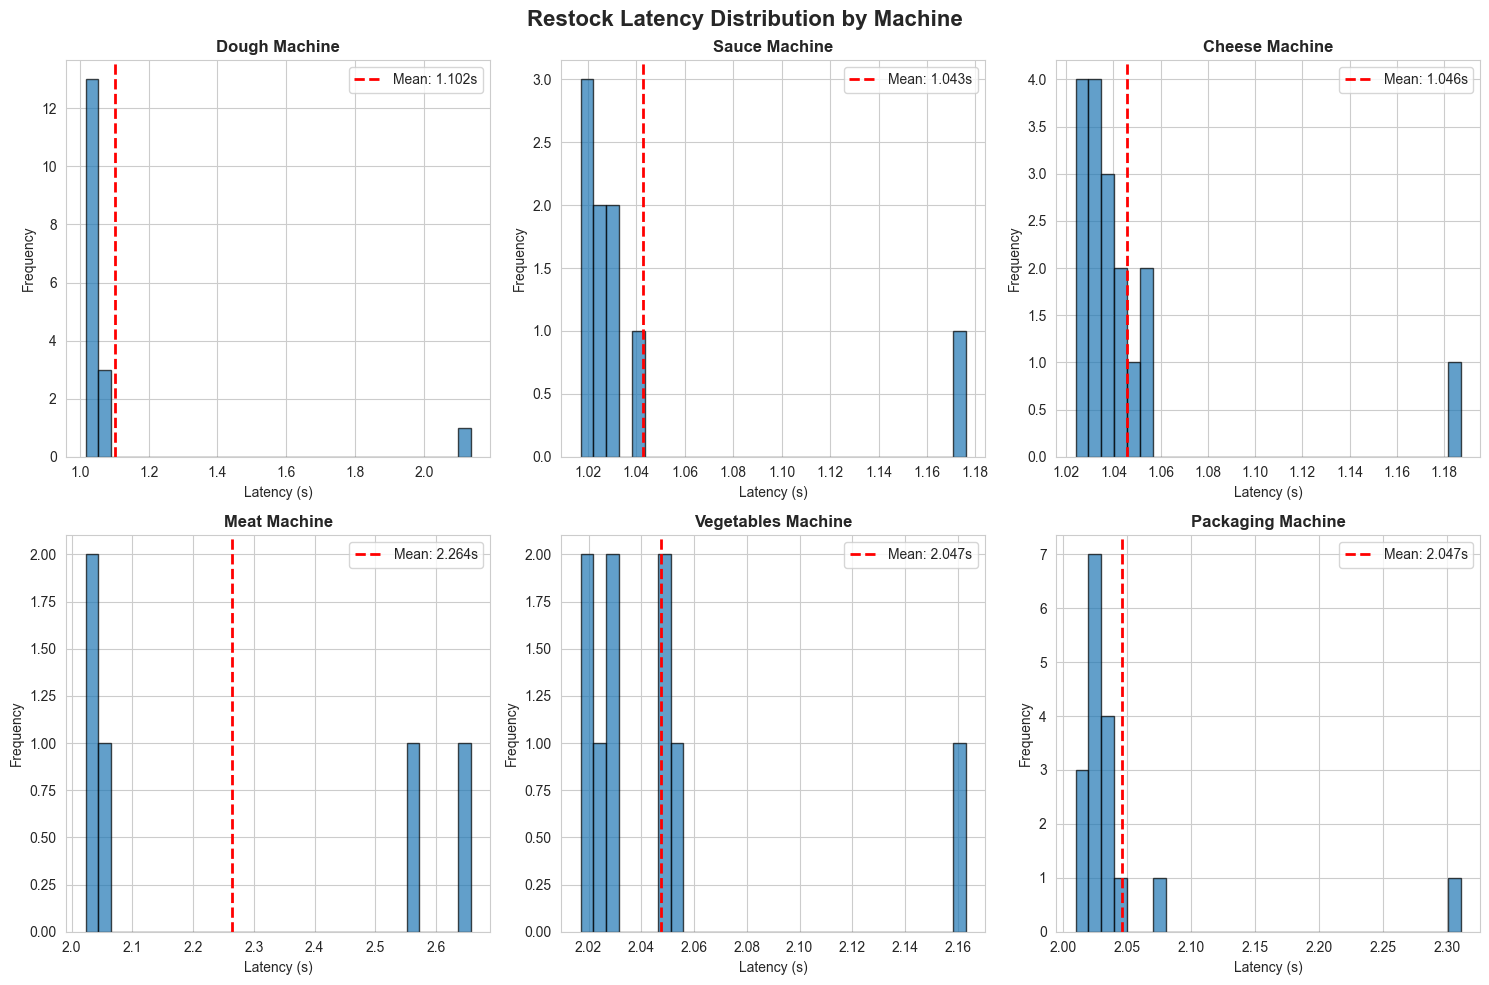

In [73]:
# ============================================================================
# 2. LATENCY DISTRIBUTION COMPARISON
# ============================================================================
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Restock Latency Distribution by Machine', fontsize=16, fontweight='bold')

for idx, (machine_name, df) in enumerate(all_machines.items()):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    ax.hist(df['RESTOCKLATENCYSEC'], bins=30, edgecolor='black', alpha=0.7)
    ax.set_title(f'{machine_name.capitalize()} Machine', fontweight='bold')
    ax.set_xlabel('Latency (s)')
    ax.set_ylabel('Frequency')
    ax.axvline(df['RESTOCKLATENCYSEC'].mean(), color='red', 
               linestyle='--', linewidth=2, label=f'Mean: {df["RESTOCKLATENCYSEC"].mean():.3f}s')
    ax.legend()

plt.tight_layout()
plt.show()

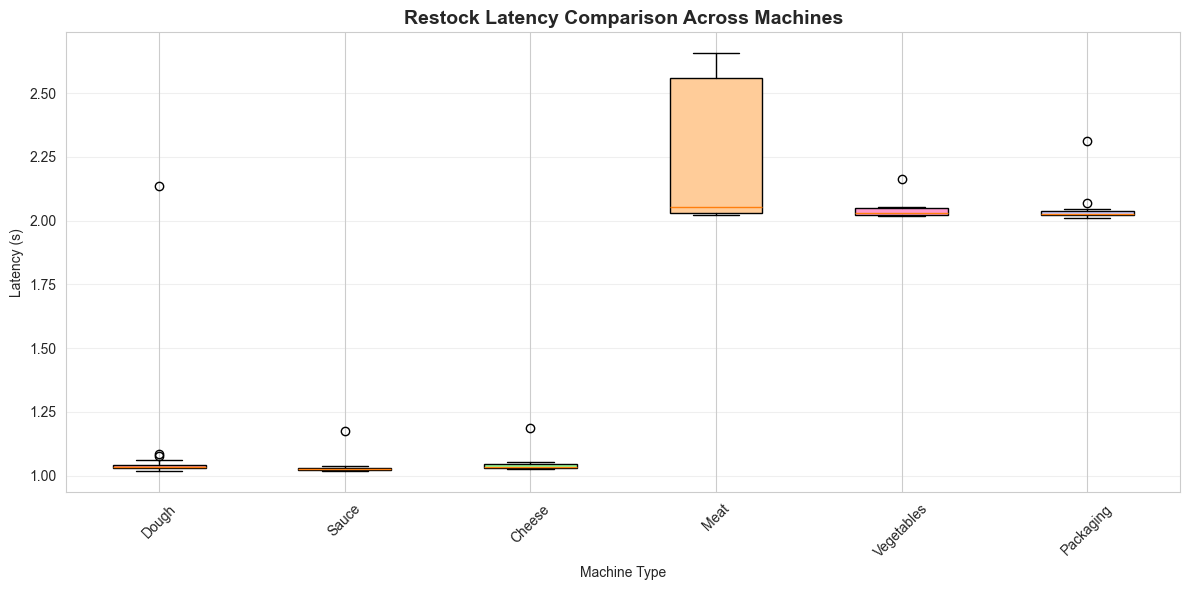

In [74]:
# ============================================================================
# 3. BOX PLOT COMPARISON
# ============================================================================
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data for box plot
data_for_boxplot = []
labels = []
for machine_name, df in all_machines.items():
    data_for_boxplot.append(df['RESTOCKLATENCYSEC'])
    labels.append(machine_name.capitalize())

bp = ax.boxplot(data_for_boxplot, labels=labels, patch_artist=True)

# Color the boxes
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC', '#CCCCFF']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_title('Restock Latency Comparison Across Machines', fontsize=14, fontweight='bold')
ax.set_ylabel('Latency (s)')
ax.set_xlabel('Machine Type')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [75]:
# ============================================================================
# 5. OUTLIER DETECTION
# ============================================================================
print("\n" + "=" * 80)
print("OUTLIER ANALYSIS (Values > 1.5 * IQR)")
print("=" * 80)

for machine_name, df in all_machines.items():
    Q1 = df['RESTOCKLATENCYSEC'].quantile(0.25)
    Q3 = df['RESTOCKLATENCYSEC'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df['RESTOCKLATENCYSEC'] < lower_bound) | 
                  (df['RESTOCKLATENCYSEC'] > upper_bound)]
    
    print(f"\n{machine_name.capitalize()} Machine:")
    print(f"  Outliers detected: {len(outliers)}")
    if len(outliers) > 0:
        print(f"  Outlier values (s): {sorted(outliers['RESTOCKLATENCYSEC'].tolist())}")



OUTLIER ANALYSIS (Values > 1.5 * IQR)

Dough Machine:
  Outliers detected: 3
  Outlier values (s): [1.077, 1.083, 2.136]

Sauce Machine:
  Outliers detected: 1
  Outlier values (s): [1.176]

Cheese Machine:
  Outliers detected: 1
  Outlier values (s): [1.187]

Meat Machine:
  Outliers detected: 0

Vegetables Machine:
  Outliers detected: 1
  Outlier values (s): [2.163]

Packaging Machine:
  Outliers detected: 2
  Outlier values (s): [2.071, 2.311]


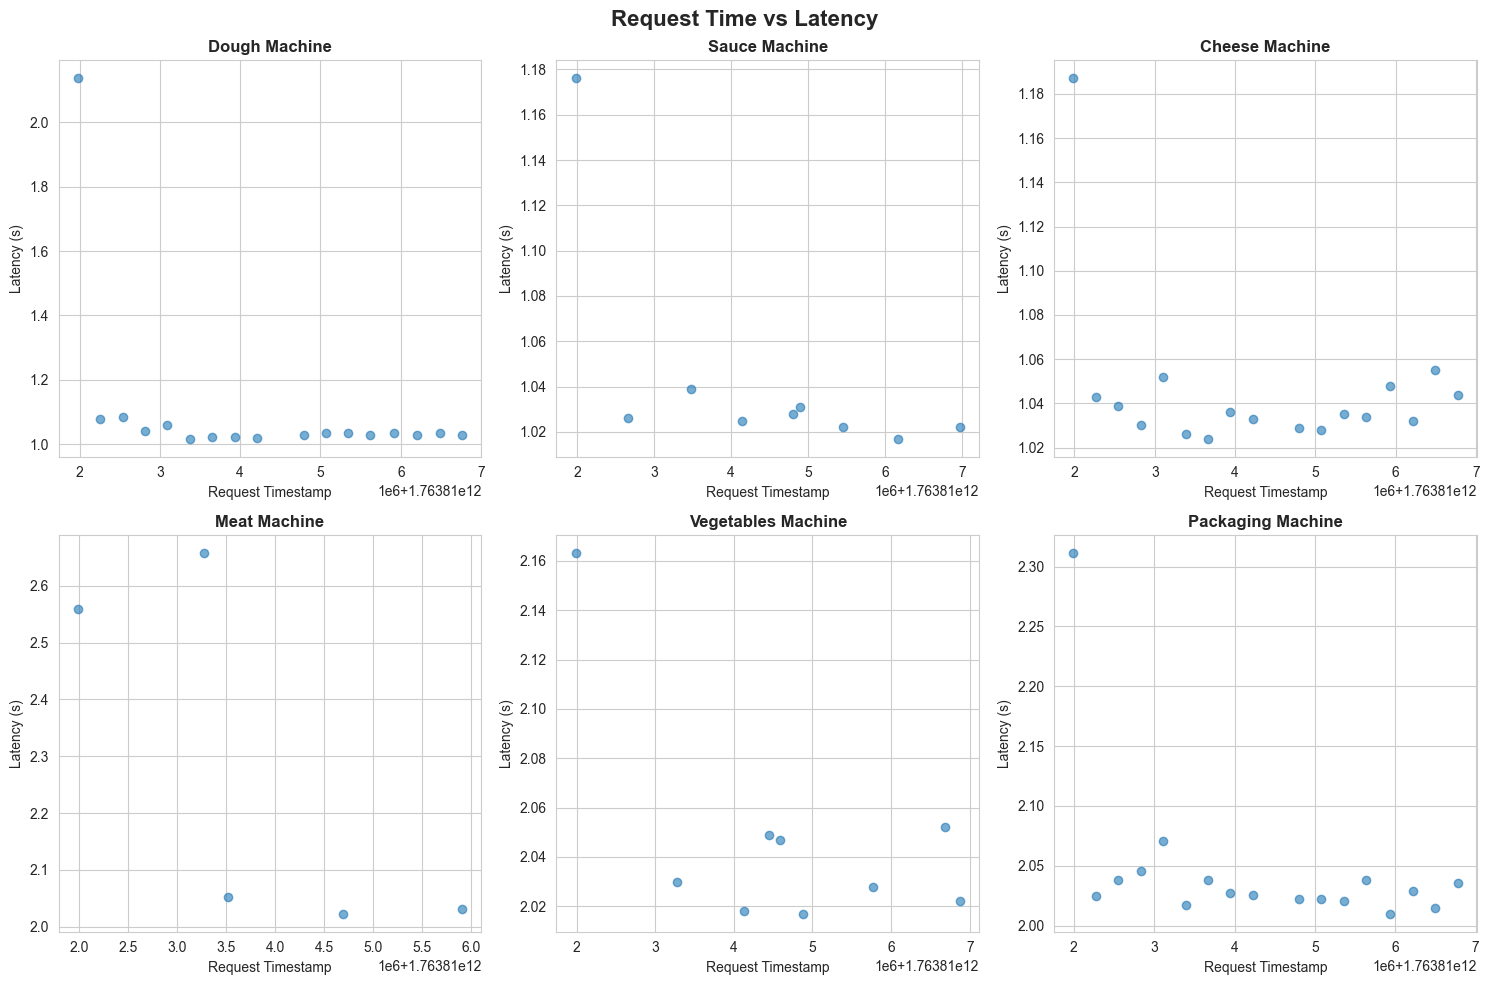

In [76]:
# ============================================================================
# 6. CORRELATION BETWEEN REQUEST TIME AND LATENCY
# ============================================================================
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Request Time vs Latency', fontsize=16, fontweight='bold')

for idx, (machine_name, df) in enumerate(all_machines.items()):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    ax.scatter(df['REQUESTTIMESTAMP'], df['RESTOCKLATENCYSEC'], alpha=0.6)
    ax.set_title(f'{machine_name.capitalize()} Machine', fontweight='bold')
    ax.set_xlabel('Request Timestamp')
    ax.set_ylabel('Latency (s)')

plt.tight_layout()
plt.show()


In [77]:
# ============================================================================
# 7. OVERALL COMPARISON TABLE
# ============================================================================
print("\n" + "=" * 80)
print("MACHINE RANKING BY PERFORMANCE METRICS")
print("=" * 80)

ranking_df = summary_df.copy()
ranking_df['Avg Rank'] = (
    ranking_df['Mean (s)'].rank() + 
    ranking_df['Median (s)'].rank() + 
    ranking_df['P95 (s)'].rank()
) / 3

ranking_df = ranking_df.sort_values('Avg Rank')
print("\n", ranking_df[['Machine', 'Mean (s)', 'Median (s)', 'P95 (s)', 'Avg Rank']].to_string(index=False))



MACHINE RANKING BY PERFORMANCE METRICS

    Machine  Mean (s)  Median (s)  P95 (s)  Avg Rank
     sauce  1.042889       1.026   1.1212  1.333333
    cheese  1.045588       1.035   1.0814  2.000000
     dough  1.102000       1.034   1.2936  2.666667
 packaging  2.046588       2.027   2.1190  4.333333
vegetables  2.047333       2.030   2.1186  4.666667
      meat  2.264400       2.052   2.6374  6.000000


## Global Analysis

In [78]:
first_timestamp=order_df['STARTTIMESTAMP'].min()
last_timestamp=order_df['ENDTIMESTAMP'].max()
total_duration_sec=(last_timestamp - first_timestamp)/1000
print(f"\nTotal Experiment Duration: {total_duration_sec:.2f} seconds ({total_duration_sec/60:.2f} minutes)")


Total Experiment Duration: 5045.98 seconds (84.10 minutes)


RESTOCK DURATION ANALYSIS
• Dough Machine Total Restock Duration: 18.73 seconds (0.31 minutes)
• Sauce Machine Total Restock Duration: 9.39 seconds (0.16 minutes)
• Cheese Machine Total Restock Duration: 17.77 seconds (0.30 minutes)
• Meat Machine Total Restock Duration: 11.32 seconds (0.19 minutes)
• Vegetables Machine Total Restock Duration: 18.43 seconds (0.31 minutes)
• Packaging Machine Total Restock Duration: 34.79 seconds (0.58 minutes)

Overall Total Restock Duration: 110.44 seconds (1.84 minutes)
Proportion of Total Experiment Time Spent on Restocking: 2.19%


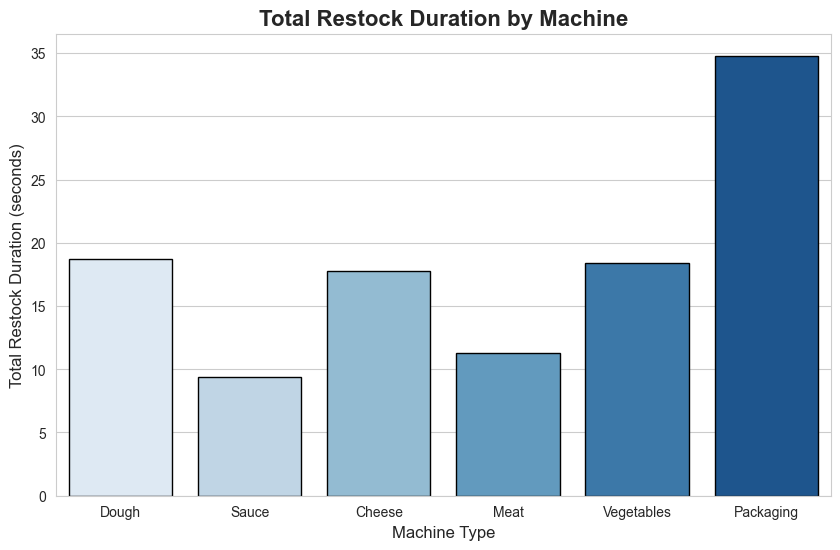

In [79]:
# Calculate restock duration for all machines
print("=" * 80)
print("RESTOCK DURATION ANALYSIS")
print("=" * 80)

for machine_name, df in all_machines.items():
    restock_duration_sec = sum(df['RESTOCKLATENCYSEC'])
    print(f"• {machine_name.capitalize()} Machine Total Restock Duration: {restock_duration_sec:.2f} seconds ({restock_duration_sec/60:.2f} minutes)")

total_restock_time = sum([sum(df['RESTOCKLATENCYSEC']) for df in all_machines.values()])
print(f"\nOverall Total Restock Duration: {total_restock_time:.2f} seconds ({total_restock_time/60:.2f} minutes)")
print(f"Proportion of Total Experiment Time Spent on Restocking: {total_restock_time/total_duration_sec*100:.2f}%")

# Bar chart of total restock durations
machine_names = []
restock_durations = []
for machine_name, df in all_machines.items():
    machine_names.append(machine_name.capitalize())
    restock_durations.append(sum(df['RESTOCKLATENCYSEC']))
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=machine_names, y=restock_durations, palette='Blues', edgecolor='black')
plt.title('Total Restock Duration by Machine', fontsize=16, fontweight='bold')
plt.xlabel('Machine Type', fontsize=12)
plt.ylabel('Total Restock Duration (seconds)', fontsize=12)
plt.show()

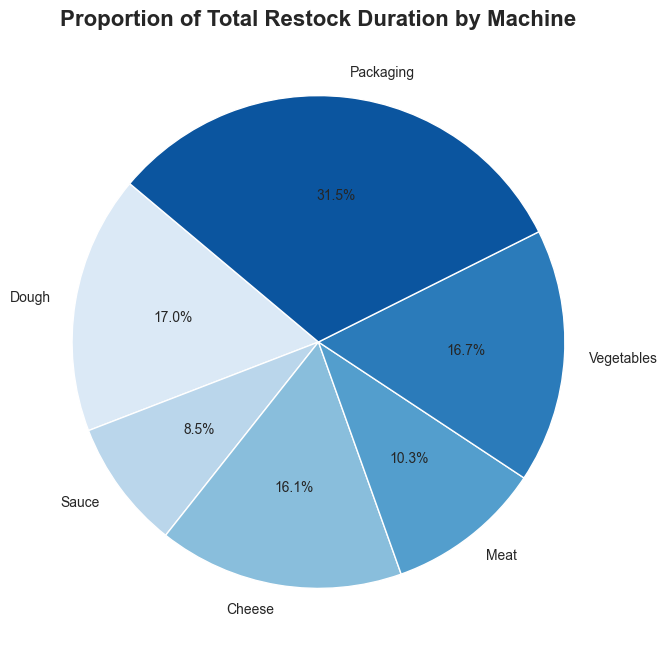

In [80]:
# Cake chart of restock duration proportions
plt.figure(figsize=(8, 8))
plt.pie(restock_durations, labels=machine_names, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Blues', len(machine_names)))
plt.title('Proportion of Total Restock Duration by Machine', fontsize=16, fontweight='bold')
plt.show()

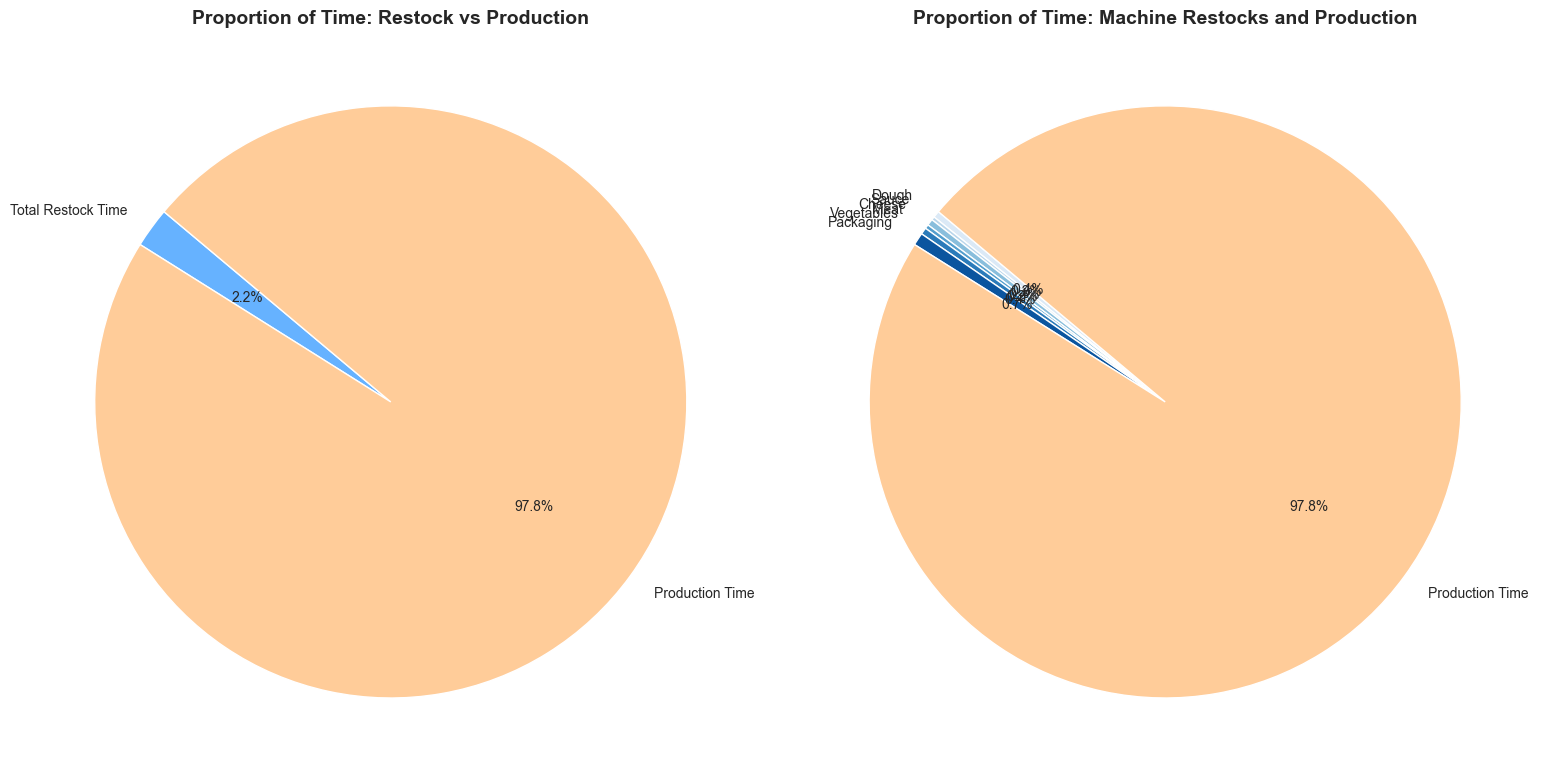

In [81]:
# Combine both pie charts in the same figure using subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Left pie chart: Total Restock vs Production Time
other_time = total_duration_sec - total_restock_time
axes[0].pie([total_restock_time, other_time], 
            labels=['Total Restock Time', 'Production Time'], 
            autopct='%1.1f%%', 
            startangle=140, 
            colors=['#66B2FF', '#FFCC99'])
axes[0].set_title('Proportion of Time: Restock vs Production', fontsize=14, fontweight='bold')

# Right pie chart: Individual Machine Restocks and Production Time
items = restock_durations + [other_time]
labels = machine_names + ['Production Time']
axes[1].pie(items, 
            labels=labels, 
            autopct='%1.1f%%', 
            startangle=140, 
            colors=sns.color_palette('Blues', len(machine_names)) + ['#FFCC99'])
axes[1].set_title('Proportion of Time: Machine Restocks and Production', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()